In [1]:
!pip install -Uqq fastai
!pip install -Uqq librosa

In [2]:
from fastai.data.all import *
from fastai.vision.all import *
import librosa
from IPython.display import Audio
from IPython.utils import io
import re
import itertools
import matplotlib.pyplot as plt
sys.path.append('../')

In [3]:
#path = Path("C:\\Users\\Rango\\Projects\\Lumen\\Dataset\\Dataset\\IRMAS_Training_Data\\")
path = Path("C:\\Users\\Ivkalu\\Documents\\LumenDataset\\Dataset\\IRMAS_Training_Data\\")

get_song_files = FileGetter(extensions='.wav', recurse=True)
files = get_song_files(path)
print(f"(#{len(files)})", files[:6])

(#6705) [Path('C:/Users/Ivkalu/Documents/LumenDataset/Dataset/IRMAS_Training_Data/cel/008__[cel][nod][cla]0058__1.wav'), Path('C:/Users/Ivkalu/Documents/LumenDataset/Dataset/IRMAS_Training_Data/cel/008__[cel][nod][cla]0058__2.wav'), Path('C:/Users/Ivkalu/Documents/LumenDataset/Dataset/IRMAS_Training_Data/cel/008__[cel][nod][cla]0058__3.wav'), Path('C:/Users/Ivkalu/Documents/LumenDataset/Dataset/IRMAS_Training_Data/cel/012__[cel][nod][cla]0043__1.wav'), Path('C:/Users/Ivkalu/Documents/LumenDataset/Dataset/IRMAS_Training_Data/cel/012__[cel][nod][cla]0043__2.wav'), Path('C:/Users/Ivkalu/Documents/LumenDataset/Dataset/IRMAS_Training_Data/cel/012__[cel][nod][cla]0043__3.wav')]


In [4]:
def file_labels(pat: Path):
    r = re.search("\[[^(\[\])]+\]", pat.name)
    if r:
        return [r.group()[1:-1]]
    return []

In [5]:
song_path = path/"cel"/"[cel][cla]0001__1.wav"
file_labels(song_path)

['cel']

In [6]:
y, sr = librosa.load(song_path)

print("Sample rate:", sr)
print("Length of audio time series:", y.shape[0])
print("Time:", librosa.load(song_path)[0].shape[0]/librosa.load(song_path)[1], "s")

Sample rate: 22050
Length of audio time series: 66150
Time: 3.0 s


We can calculate the length of the audio file by dividing the length of audio time series (number of samples) by sample rate (nubmer of samples per second).

C:\Users\Ivkalu\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


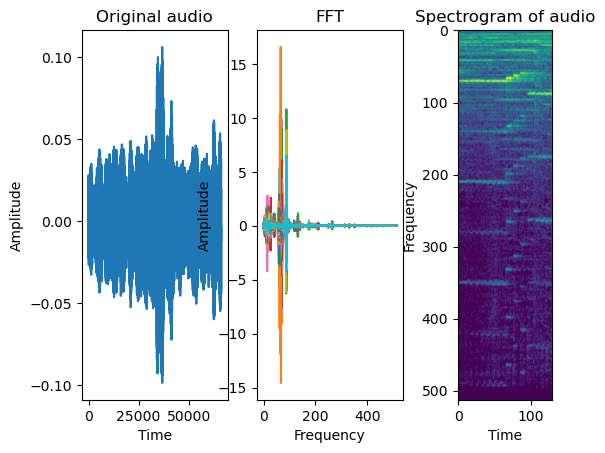

(66150,)
(513, 130)
(513, 130)


In [7]:
n_fft = 1024
hop_length = 512
f_min = 20
f_max = 8000

def spectogram(song):
    stft = librosa.stft(song, n_fft=n_fft, hop_length=hop_length)
    stft_magnitude, _ = librosa.magphase(stft)
    stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude)
    return stft_magnitude_db
    
song, _ = librosa.load(song_path)
song_fft = librosa.stft(song, n_fft=n_fft, hop_length=hop_length)
spec = spectogram(song)

plt.subplot(131)
plt.title('Original audio')
plt.plot(song)
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.subplot(132)
plt.title('FFT')
plt.plot(song_fft)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.subplot(133)
plt.title('Spectrogram of audio')
plt.imshow(spec)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

print(song.shape)
print(song_fft.shape)
print(spec.shape)

In [8]:
songsMap = dict()
for song in get_song_files(path):
    label = file_labels(song)
    if label[0] not in songsMap:
        songsMap[label[0]] = []
    songsMap[label[0]].append(song)

In [9]:
MAX_DATA_SIZE = 100
celloAvg = sum(spectogram(librosa.load(song)[0]) for song in songsMap["cel"][:MAX_DATA_SIZE])/MAX_DATA_SIZE

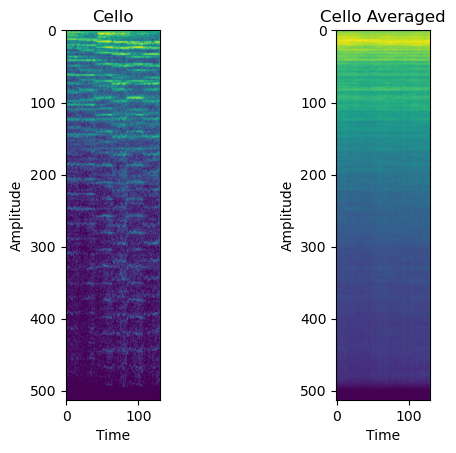

In [10]:
plt.subplot(1,2,1)
plt.title('Cello')
plt.imshow(spectogram(librosa.load(songsMap['cel'][0])[0]))
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.subplot(1,2,2)
plt.title('Cello Averaged')
plt.imshow(celloAvg)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [11]:
X = []
y = []
for typee in songsMap:
    for song in songsMap[typee][:MAX_DATA_SIZE]:
        X.append(librosa.load(song)[0])
        y.append(typee)
X = np.array(X)
y = np.array(y)

In [12]:
class AvgModel:
    def __init__(self, X_train, y_train):
        dictionary = {key: [] for key in y_train}
        
        for i in range(len(X_train)):
            dictionary[y_train[i]].append(X_train[i])
            
        for i in dictionary:
            dictionary[i] = sum(dictionary[i]) / len(dictionary[i])
            
        self.dictionary = dictionary
        
        
    def _predict(self, x):
        l = [(np.sum((x-self.dictionary[typee])**2), typee) for typee in self.dictionary]
        return min(l)[1]
        
    def predict(self, X_test):
        predictions = [self._predict(x) for x in X_test]
        return predictions
    
    def plot(self):
        i = 1
        for typee in self.dictionary:
            plt.subplot(2,6,i)
            plt.imshow(self.dictionary[typee])
            plt.title(typee)
            plt.xticks([])
            plt.yticks([])
            i+=1
        plt.show()

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

avgModel = AvgModel(X_train, y_train)
accuracy_test = sum(avgModel.predict(X_test) == y_test) / len(y_test)
accuracy_test

0.12947658402203857

In [14]:
X_aug = spectogram(X)
X_train, X_test, y_train, y_test = train_test_split(X_aug, y, test_size=0.33, random_state=42)

avgModel = AvgModel(X_train, y_train)
accuracy_test = sum(avgModel.predict(X_test) == y_test) / len(y_test)
accuracy_test

0.3443526170798898

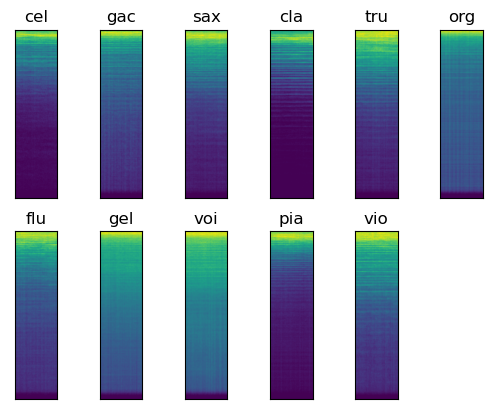

In [15]:
avgModel.plot()

# Spectral centroid

In [16]:
cel, _ = librosa.load(songsMap["cel"][0])
gac, _ = librosa.load(songsMap["gac"][0])
sax, _ = librosa.load(songsMap["sax"][0])

In [17]:
sc_cel = librosa.feature.spectral_centroid(y=cel, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
sc_gac = librosa.feature.spectral_centroid(y=gac, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
sc_sax = librosa.feature.spectral_centroid(y=sax, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]

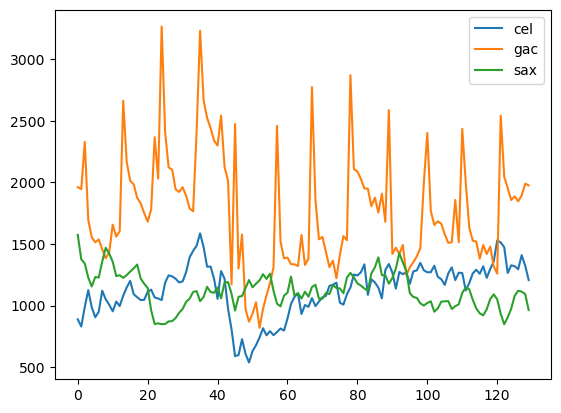

In [18]:
plt.plot(sc_cel, label="cel")
plt.plot(sc_gac, label="gac")
plt.plot(sc_sax, label="sax")
plt.legend()
plt.show()

# Spectral bandwidth

In [19]:
sc_cel = librosa.feature.spectral_bandwidth(y=cel, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
sc_gac = librosa.feature.spectral_bandwidth(y=gac, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
sc_sax = librosa.feature.spectral_bandwidth(y=sax, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]

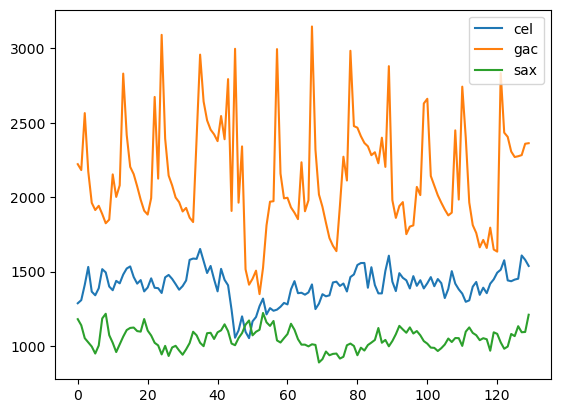

In [20]:
plt.plot(sc_cel, label="cel")
plt.plot(sc_gac, label="gac")
plt.plot(sc_sax, label="sax")
plt.legend()
plt.show()

In [21]:
def centroid(song):
    c = librosa.feature.spectral_centroid(y=song, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
    return c

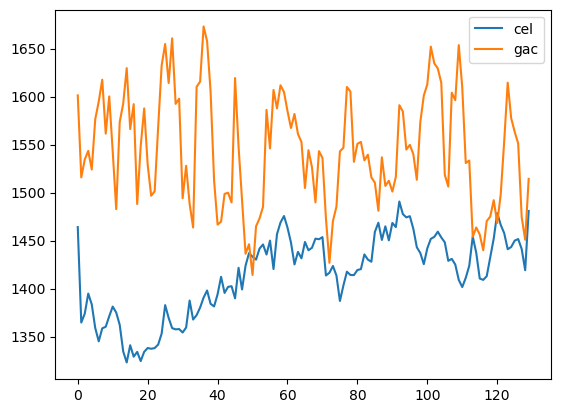

In [22]:
sc_cel_avg = sum(centroid(librosa.load(song)[0]) for song in songsMap["cel"][:MAX_DATA_SIZE])/MAX_DATA_SIZE
sc_gac_avg = sum(centroid(librosa.load(song)[0]) for song in songsMap["gac"][:MAX_DATA_SIZE])/MAX_DATA_SIZE

plt.plot(sc_cel_avg, label="cel")
plt.plot(sc_gac_avg, label="gac")
plt.legend()
plt.show()

In [23]:
X_centroid = [centroid(x) for x in X]
X_train, X_test, y_train, y_test = train_test_split(X_centroid, y, test_size=0.33, random_state=42)

avgModel = AvgModel(X_train, y_train)
accuracy_test = sum(avgModel.predict(X_test) == y_test) / len(y_test)
accuracy_test

0.1928374655647383